<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#FCN8s-(VGG-imageNet-weight)" data-toc-modified-id="FCN8s-(VGG-imageNet-weight)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>FCN8s (VGG imageNet weight)</a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from utils import label_accuracy_score, seed_everything
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P40
1


## 하이퍼파라미터 세팅 및 seed 고정

In [2]:
batch_size = 8   # Mini-batch size
num_epochs = 20
learning_rate = 0.0003

In [3]:
# seed 고정
random_seed = 21

seed_everything(random_seed)

## Dataset 정의 및 DataLoader 할당

In [4]:
from dataset import CustomDataLoader

In [6]:
dataset_path = '../input/data'

In [7]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])


# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(dataset_path=dataset_path, data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(dataset_path=dataset_path, data_dir=val_path, mode='val', transform=val_transform)



# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2,)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2,)


loading annotations into memory...
Done (t=3.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.82s)
creating index...
index created!


## 데이터 샘플 시각화

image shape: [3, 512, 512]
mask shape:  [11, 512, 512]


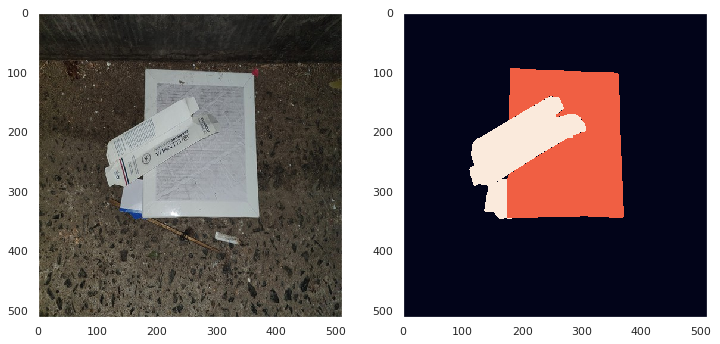

In [8]:
# train_loader의 output 결과(image 및 mask) 확인
for i, (imgs, masks) in enumerate(train_loader):
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
# print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i+1)]} for i in range(11) if (masks[0][i]==1).sum()>0])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)

mask_img = np.zeros([512, 512])
mask = np.float32(masks[0])
for i in range(11):
    if (masks[0][i]==1).sum()>0:
        mask_img = mask_img + mask[i]*(i+1)
ax2.imshow(mask_img)
ax2.grid(False)

plt.show()

image shape: [3, 512, 512]
mask shape:  [11, 512, 512]


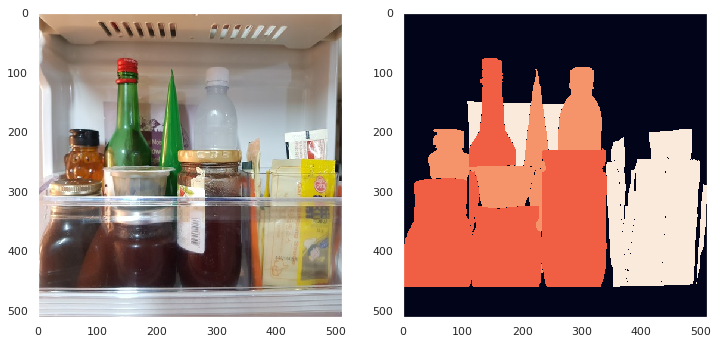

In [9]:
# val_loader의 output 결과(image 및 mask) 확인
for i, (imgs, masks) in enumerate(val_loader):
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

# print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i+1)]} for i in range(11) if (masks[0][i]==1).sum()>0])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)

mask_img = np.zeros([512, 512])
mask = np.float32(temp_masks[0])
for i in range(11):
    if (masks[0][i]==1).sum()>0:
        mask_img = mask_img + mask[i]*(i+1)
ax2.imshow(mask_img)
ax2.grid(False)

plt.show()

## Loss 정의 

In [10]:
from loss import FocalBinaryTverskyLoss, MultiTverskyLoss

## Custom model

### FCN8s (VGG imageNet weight) & PSPNet

In [11]:
import torch.nn as nn
import torch.optim as optim
# from torchvision import models
# from torchvision.models import vgg16

In [12]:
import segmentation_models_pytorch as smp

In [13]:
model = smp.PSPNet(
    encoder_name="vgg19_bn",
    encoder_weights="imagenet",
    in_channels=3,
    classes=11,
    activation='sigmoid'
)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /opt/ml/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [14]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
x = torch.randn([2, 3, 512, 512])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)

input shape :  torch.Size([2, 3, 512, 512])
output shape :  torch.Size([2, 11, 512, 512])


In [15]:
loss = MultiTverskyLoss(0.5, 0.5, 0.75)
metrics = [
    smp.utils.metrics.IoU(threshold=0.5)
]

optimizer = torch.optim.Adam(
    [
        dict(params=model.parameters(), lr=learning_rate),
    ]
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=0.00001)

In [16]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [ ]:
max_score = 0

for i in range(0, 60):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './smp_test/best_model(PSP)(vgg19_bn).pth')
        print('Model saved!')
    scheduler.step()



Epoch: 0
valid: 100%|██████████| 82/82 [00:23<00:00,  3.54it/s, <bound method MultiTverskyLoss.__name__ of MultiTverskyLoss()> - 0.8631, iou_score - 0.2076]
Model saved!

Epoch: 1
valid: 100%|██████████| 82/82 [00:23<00:00,  3.54it/s, <bound method MultiTverskyLoss.__name__ of MultiTverskyLoss()> - 0.838, iou_score - 0.2725] 
Model saved!

Epoch: 2
valid: 100%|██████████| 82/82 [00:23<00:00,  3.56it/s, <bound method MultiTverskyLoss.__name__ of MultiTverskyLoss()> - 0.8254, iou_score - 0.367] 
Model saved!

Epoch: 3
valid: 100%|██████████| 82/82 [00:23<00:00,  3.50it/s, <bound method MultiTverskyLoss.__name__ of MultiTverskyLoss()> - 0.8262, iou_score - 0.4042]
Model saved!

Epoch: 4
valid: 100%|██████████| 82/82 [00:23<00:00,  3.54it/s, <bound method MultiTverskyLoss.__name__ of MultiTverskyLoss()> - 0.8207, iou_score - 0.4368]
Model saved!

Epoch: 5
valid: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s, <bound method MultiTverskyLoss.__name__ of MultiTverskyLoss()> - 0.8022, iou_sco

## 모델 로드 및 추론

In [19]:
# best model 저장된 경로
model_path = './smp_test/best_model.pth'

# best model 불러오기
model = torch.load(model_path, map_location=device)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
model.eval()

PSPNet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

In [20]:
# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          num_workers=0,)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [21]:
# 첫번째 batch의 추론 결과 확인
for imgs, infos in test_loader:
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(temp_images.to(device))
    # oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    break

infos

{'license': tensor([0]),
 'url': tensor([0]),
 'file_name': ['batch_01_vt/0021.jpg'],
 'height': tensor([512]),
 'width': tensor([512]),
 'date_captured': tensor([0]),
 'id': tensor([0])}

In [22]:
pred = outs[0].detach().cpu().numpy()
labeled = np.zeros((pred.shape[1], pred.shape[1]))

for i in range(pred.shape[1]):
    for j in range(pred.shape[2]):
        logit, idx = 0.5, -1
        for k in range(pred.shape[0]):
            if logit<pred[k][j][i]:
                idx = k
                logit = pred[k][j][i]
        labeled[j][i] = idx

labeled = labeled+1
labeled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [11, 512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {3, 'Paper'}, {9, 'Plastic bag'}]


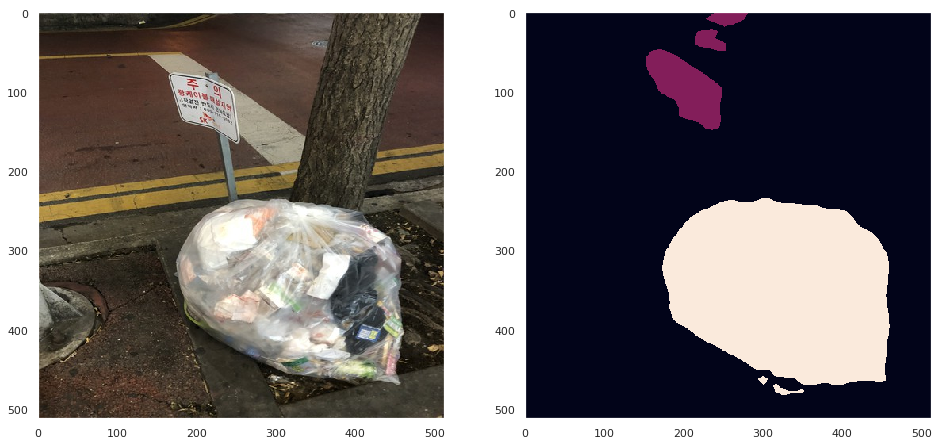

In [23]:
i = 0
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(pred.shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(labeled.reshape(-1)))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)

# Predicted
ax2.imshow(labeled)
ax2.grid(False)

plt.show()

In [24]:
from tqdm import tqdm

def test(model, data_loader, device):
    size = 256
    # transform = A.Compose([])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = []
    
    with torch.no_grad():
        for step, batch_out in tqdm(enumerate(test_loader)):
            imgs, image_info = batch_out
            # inference (512 x 512)
            mask = model(imgs.to(device))[0]
            
            # resize (256 x 256)
            a, b = torch.max(mask, dim=0)
            a = a.detach().cpu().numpy()
            b = b.detach().cpu().numpy()
            b += 1
            b[a<0.5] = 0
            transformed = A.Resize(256, 256, p=1)(image=a, mask=b)
            mask = transformed['mask']
            
            oms = mask.astype(int)
            preds_array.append(oms)
            
            file_name_list.append(image_info['file_name'])
    print("End prediction.")
    
    return file_name_list, preds_array

In [25]:
# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

3it [00:00, 26.51it/s]

Start prediction.


837it [00:29, 28.85it/s]

End prediction.


In [26]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)


# PredictionString 대입
for file_name, string in zip(file_names, preds):
    pred_string = [str(e) for sublist in string.tolist() for e in sublist]
    submission = submission.append({"image_id" : file_name[0], "PredictionString" : ' '.join(pred_string)}, ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/PSPNet_01.csv", index=False)

## Reference

